# 加法器:
# 本程式為建構一深度學習模型，將其訓練成一個加法器，輸入一段三位數 + 三位數之算式，計算及答案。 並比較不同神經元個數、Epoch次數之影響。

## 匯入所需library，主要使用keras建立神經網路

In [12]:
import numpy as np
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

## 自行生成加法算式資料

In [3]:
DIGITS = 3
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '

# Generate Data
questions = []
expected = []
print('Generating data...')
for a in range(0, 999):
    for b in range(0, 999):
        q = '{}+{}'.format(str(a), str(b))    # 將 +號 插進兩數字中，產生數學式的字串
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        questions.append(query)
        expected.append(ans)
        
print('Finish!')

Generating data...
Finish!


In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))      # char to integer
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))      # integer to char
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)
      
ctable = CharacterTable(chars)

## 將產生好的資料化為 One-Hot Encoding

In [5]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.int)  
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.int)

# One-Hot encoding
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)
    
print('Finish!')

Vectorization...
Finish!


## 拆分訓練、驗證、測試資料集

In [6]:
test_ratio = 0.2
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_ratio, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=test_ratio, random_state=0)

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

print('Validation Data:')
print(valid_x.shape)
print(valid_y.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(638720, 7, 12)
(638720, 4, 12)
Validation Data:
(159680, 7, 12)
(159680, 4, 12)
Testing Data:
(199601, 7, 12)
(199601, 4, 12)


In [7]:
ctrain_x = train_x.reshape(train_x.shape[0], -1, 1).squeeze(axis=2)
ctest_x = test_x.reshape(test_x.shape[0], -1, 1).squeeze(axis=2)
ctrain_y = train_y.reshape(train_y.shape[0], -1, 1).squeeze(axis=2)
ctest_y = test_y.reshape(test_y.shape[0], -1, 1).squeeze(axis=2)
cvalid_x = valid_x.reshape(valid_x.shape[0], -1, 1).squeeze(axis=2)
cvalid_y = valid_y.reshape(valid_y.shape[0], -1, 1).squeeze(axis=2)

## 固定訓練10個 epochs, 以不同的隱藏層神經元個數訓練，比較 accuracy

In [15]:
acc_list = []
for n_neurons in range(50, 501, 50):
    input1 = Input(shape=(84,))
    w1 = Dense(n_neurons, activation='relu', name='weight1')
    dense1 = w1(input1)
    w2 = Dense(48, activation='softmax', name='weight2')
    output1 = w2(dense1)

    model = Model(inputs=[input1], outputs=[output1])
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y], epochs=10)
    
    # 預測測試集
    predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 12)
    
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(test_y)):
        labels.append(ctable.decode(test_y[i]))
        ans.append(ctable.decode(predicted[i]))
    # 計算測試資料正確率
    acc = accuracy_score(ans, labels)
    acc_list.append(acc)

    

Train on 638720 samples, validate on 159680 samples
Epoch 1/10
638720/638720 [==============================] - 24s 38us/step - loss: 10.5529 - acc: 0.4666 - val_loss: 9.5199 - val_acc: 0.3977
Epoch 2/10
638720/638720 [==============================] - 21s 33us/step - loss: 9.2665 - acc: 0.3688 - val_loss: 9.0893 - val_acc: 0.3512
Epoch 3/10
638720/638720 [==============================] - 24s 37us/step - loss: 9.0116 - acc: 0.3558 - val_loss: 8.9493 - val_acc: 0.3568
Epoch 4/10
638720/638720 [==============================] - 22s 34us/step - loss: 8.9206 - acc: 0.3538 - val_loss: 8.8824 - val_acc: 0.4031
Epoch 5/10
638720/638720 [==============================] - 21s 33us/step - loss: 8.8709 - acc: 0.3518 - val_loss: 8.8380 - val_acc: 0.3567
Epoch 6/10
638720/638720 [==============================] - 24s 38us/step - loss: 8.8323 - acc: 0.3508 - val_loss: 8.8061 - val_acc: 0.3362
Epoch 7/10
638720/638720 [==============================] - 22s 34us/step - loss: 8.8060 - acc: 0.3486 - va

638720/638720 [==============================] - 42s 66us/step - loss: 6.4666 - acc: 0.2562 - val_loss: 6.4420 - val_acc: 0.2301
Epoch 8/10
638720/638720 [==============================] - 50s 78us/step - loss: 6.4330 - acc: 0.2534 - val_loss: 6.4134 - val_acc: 0.2114
Epoch 9/10
638720/638720 [==============================] - 42s 65us/step - loss: 6.4053 - acc: 0.2528 - val_loss: 6.3931 - val_acc: 0.2978
Epoch 10/10
638720/638720 [==============================] - 42s 66us/step - loss: 6.3831 - acc: 0.2512 - val_loss: 6.3628 - val_acc: 0.2733
Train on 638720 samples, validate on 159680 samples
Epoch 1/10
638720/638720 [==============================] - 50s 78us/step - loss: 8.2235 - acc: 0.3332 - val_loss: 7.1404 - val_acc: 0.3128
Epoch 2/10
638720/638720 [==============================] - 50s 79us/step - loss: 6.9042 - acc: 0.2905 - val_loss: 6.7247 - val_acc: 0.2934
Epoch 3/10
638720/638720 [==============================] - 50s 79us/step - loss: 6.6405 - acc: 0.2711 - val_loss: 6.5

## 下圖可發現，隨著神經元個數變多，accuracy持續成長，並逐漸緩慢下來

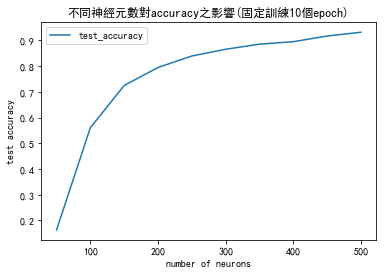

In [16]:
#coding:utf-8
plt.rcParams['font.sans-serif']=['SimHei']   # 設定中文字體
plt.title(u'不同神經元數對accuracy之影響(固定訓練10個epoch)')
plt.xlabel('number of neurons')
plt.ylabel('test accuracy')
plt.plot(np.arange(50, 501, 50), acc_list, label='test_accuracy')
plt.legend()
plt.show()

## 固定神經元個數為300，比較訓練不同 epoch 次數之影響，並畫出訓練過程loss與accuracy之變化

In [23]:
epoch_size = 200
input1 = Input(shape=(84,))
w1 = Dense(300, activation='relu', name='weight1')
dense1 = w1(input1)
w2 = Dense(48, activation='softmax', name='weight2')
output1 = w2(dense1)

model = Model(inputs=[input1], outputs=[output1])
model.compile(optimizer='adam', loss=['categorical_crossentropy'])

accuracy_list = []
train_loss_list = []
val_loss_list = []

for i in range(1, epoch_size+1):
    print('Epoch {}/{}'.format(i, epoch_size))
    h = model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y])
    train_loss_list.append(h.history['loss'][0])
    val_loss_list.append(h.history['val_loss'][0])
    
    # 預測驗證集
    predicted = model.predict(cvalid_x).reshape(cvalid_x.shape[0], 4, 12)
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(valid_y)):
      labels.append(ctable.decode(valid_y[i]))
      ans.append(ctable.decode(predicted[i]))

    # 計算正確率
    acc = accuracy_score(ans, labels)
    print('accuracy: ', acc)
    accuracy_list.append(acc)


Epoch 1/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 35s 54us/step - loss: 8.3897 - val_loss: 7.3085
accuracy:  0.6156625751503007
Epoch 2/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 36s 56us/step - loss: 7.0512 - val_loss: 6.8765
accuracy:  0.7414015531062125
Epoch 3/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 33s 52us/step - loss: 6.7867 - val_loss: 6.7056
accuracy:  0.7803669839679359
Epoch 4/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 31s 49us/step - loss: 6.6599 - val_loss: 6.6040
accuracy:  0.807314629258517
Epoch 5/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 31s 48us/step - loss: 6.5824 - val_loss: 6.5455
accuracy:  0.8209794589178

638720/638720 [==============================] - 30s 48us/step - loss: 6.2022 - val_loss: 6.1963
accuracy:  0.9119175851703407
Epoch 42/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 31s 48us/step - loss: 6.1994 - val_loss: 6.1984
accuracy:  0.9122870741482966
Epoch 43/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 31s 49us/step - loss: 6.1972 - val_loss: 6.1962
accuracy:  0.9120741482965932
Epoch 44/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 30s 48us/step - loss: 6.1942 - val_loss: 6.1829
accuracy:  0.9106650801603207
Epoch 45/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 30s 47us/step - loss: 6.1923 - val_loss: 6.1835
accuracy:  0.9160571142284569
Epoch 46/200
Train on 638720 samples, validate on 159680 samples


638720/638720 [==============================] - 35s 55us/step - loss: 6.1317 - val_loss: 6.1394
accuracy:  0.9294651803607215
Epoch 83/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 35s 54us/step - loss: 6.1305 - val_loss: 6.1320
accuracy:  0.9285508517034068
Epoch 84/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 35s 55us/step - loss: 6.1292 - val_loss: 6.1277
accuracy:  0.9298221442885771
Epoch 85/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 35s 55us/step - loss: 6.1279 - val_loss: 6.1225
accuracy:  0.9320140280561122
Epoch 86/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 35s 54us/step - loss: 6.1275 - val_loss: 6.1246
accuracy:  0.9305110220440882
Epoch 87/200
Train on 638720 samples, validate on 159680 samples


accuracy:  0.9374686873747495
Epoch 123/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0992 - val_loss: 6.0946
accuracy:  0.9377066633266533
Epoch 124/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0983 - val_loss: 6.1227
accuracy:  0.9369050601202404
Epoch 125/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 27s 42us/step - loss: 6.0986 - val_loss: 6.0955
accuracy:  0.9368800100200401
Epoch 126/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0974 - val_loss: 6.1063
accuracy:  0.9368987975951903
Epoch 127/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0973 - va

638720/638720 [==============================] - 26s 41us/step - loss: 6.0774 - val_loss: 6.0914
accuracy:  0.9395102705410822
Epoch 164/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0767 - val_loss: 6.0772
accuracy:  0.9392785571142285
Epoch 165/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 26s 41us/step - loss: 6.0762 - val_loss: 6.0753
accuracy:  0.9408003507014028
Epoch 166/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 27s 42us/step - loss: 6.0758 - val_loss: 6.0730
accuracy:  0.9404684368737475
Epoch 167/200
Train on 638720 samples, validate on 159680 samples
Epoch 1/1
638720/638720 [==============================] - 27s 42us/step - loss: 6.0751 - val_loss: 6.0692
accuracy:  0.9410383266533067
Epoch 168/200
Train on 638720 samples, validate on 159680 sam

## 下方兩張圖:
## 第一張是隨著training epoch變多，訓練誤差和驗證誤差均持續降低。
## 第二張圖則是隨著training epoch變多，驗證accuracy持續上升至收斂

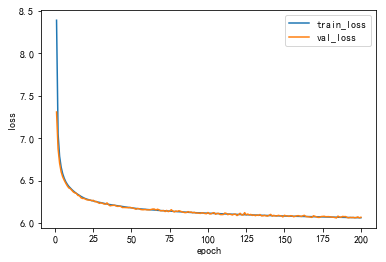

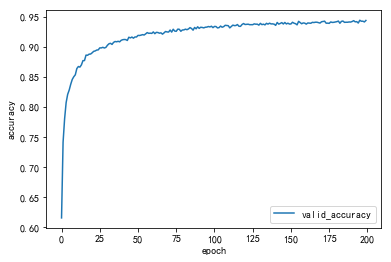

In [24]:
# 隨著 epoch 次數不同，loss 之變化
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, epoch_size+1, 1), train_loss_list, label='train_loss')
plt.plot(range(1, epoch_size+1, 1), val_loss_list, label='val_loss')
plt.legend()
plt.show()

# 隨著 epoch 次數不同，accuracy 之變化
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy_list, label='valid_accuracy' )
plt.legend()
plt.show()

## 使用測試集評估最終結果，accuracy 0.9414

In [26]:
# 預測測試集
predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 12)
# 將預測結果(one-hot編碼)轉回一般數值
labels = []
ans = []
for i in range(0, len(ctest_y)):
  labels.append(ctable.decode(test_y[i]))
  ans.append(ctable.decode(predicted[i]))

# 計算正確率
acc = accuracy_score(ans, labels)
print('accuracy: ', acc)

accuracy:  0.9414732391120285
